In [2]:
import pandas as pd

import os

# Limit threads globally (optional but useful)
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"



import pandas as pd

# Load and combine datasets (as before)
datasets = {
    'benign': pd.read_csv('/home/azwad/Works/CIC-IoT/labeled_dataset_benign.csv'),
    'dns': pd.read_csv('/home/azwad/Works/CIC-IoT/labeled_dataset_DNS_spoofing.csv'),
    'mitm': pd.read_csv('/home/azwad/Works/CIC-IoT/labeled_dataset_MITM_ArpSpoofing.csv')
}
combined_df = pd.concat([datasets['benign'], datasets['dns'], datasets['mitm']], ignore_index=True)
combined_df = combined_df.drop('dst_mac', axis=1)

print(combined_df.shape)

/tmp/ipykernel_4308/2180839656.py:19: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  'dns': pd.read_csv('/home/azwad/Works/CIC-IoT/labeled_dataset_DNS_spoofing.csv'),
/tmp/ipykernel_4308/2180839656.py:20: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  'mitm': pd.read_csv('/home/azwad/Works/CIC-IoT/labeled_dataset_MITM_ArpSpoofing.csv')


(883525, 135)


In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# --- Helper: Check if a value is a MAC address ---
def is_hex_mac(mac):
    if pd.isna(mac) or mac == 'unknown':
        return False
    pattern = r'^([0-9A-Fa-f]{2}[:-]){5}([0-9A-Fa-f]{2})$'
    return bool(re.match(pattern, str(mac)))

# --- Step 1: Filter + Clean ---
# Remove rows where src_mac is a real MAC address
combined_df = combined_df[~combined_df['src_mac'].apply(is_hex_mac)]

# Drop duplicates
print(f"Number of duplicate rows: {combined_df.duplicated().sum()}")
combined_df = combined_df.drop_duplicates()
print(f"New shape after removing duplicates: {combined_df.shape}")

# Identify categorical columns
categorical_cols = [col for col in combined_df.columns if combined_df[col].nunique() < 10 or combined_df[col].dtype == 'object']
print(f"Categorical features: {categorical_cols}")

# Convert all categorical columns to string and fill missing with 'unknown'
for col in categorical_cols:
    combined_df[col] = combined_df[col].astype(str).fillna('unknown')

# Fill missing numerical values with median
numerical_cols = combined_df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    combined_df[col] = combined_df[col].fillna(combined_df[col].median())

# --- Step 2: Split target labels and features ---
X = combined_df.drop(['Label', 'src_mac'], axis=1, errors='ignore')
y_attack = combined_df['Label']
y_device = combined_df['src_mac']

# Encode device labels
le_device = LabelEncoder()
y_device_encoded = le_device.fit_transform(y_device)

# --- Step 3: Normalize and Apply PCA ---
# Keep only numeric columns
X_numeric = X.select_dtypes(include=['number'])

# Normalize features using StandardScaler (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_scaled)

# Store column names for reduced PCA components
pca_feature_names = [f'PC{i+1}' for i in range(X_reduced.shape[1])]

# Convert to DataFrame for ease of use
X_reduced_df = pd.DataFrame(X_reduced, columns=pca_feature_names, index=X.index)

print(f"\n✅ Number of PCA features: {X_reduced.shape[1]}")
print(f"✅ Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# --- Step 4: Trace which original features contribute most to each PC ---
original_features = X_numeric.columns
pca_components = pd.DataFrame(pca.components_, columns=original_features, index=pca_feature_names)

# Show top contributing features for each PCA component
print("\n🔍 Top contributing features per PCA component:")
for pc in pca_components.index:
    top_features = pca_components.loc[pc].abs().sort_values(ascending=False).head(5)
    print(f"{pc}: {', '.join(top_features.index)}")

# --- Step 5: Train/Test Split ---
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_reduced_df, y_attack, test_size=0.2, random_state=42, stratify=y_attack
)

X_train_device, X_test_device, y_train_device, y_test_device = train_test_split(
    X_reduced_df, y_device_encoded, test_size=0.2, random_state=42, stratify=y_device_encoded
)


Number of duplicate rows: 0
New shape after removing duplicates: (432555, 135)
Categorical features: ['src_mac', 'src_ip', 'dst_ip', 'port_class_dst', 'l4_tcp', 'l4_udp', 'ttl', 'handshake_version', 'handshake_ciphersuites', 'tls_server', 'http_request_method', 'http_host', 'http_response_code', 'user_agent', 'dns_server', 'dns_query_type', 'dns_len_ans', 'device_mac', 'eth_src_oui', 'eth_dst_oui', 'highest_layer', 'http_uri', 'http_content_len', 'http_content_type', 'icmp_type', 'icmp_checksum_status', 'icmp_data_size', 'Label']

✅ Number of PCA features: 23
✅ Total variance explained: 0.9527

🔍 Top contributing features per PCA component:
PC1: channel_10_mean, channel_30_mean, channel_60_mean, stream_30_mean, stream_60_mean
PC2: src_ip_5_mean, src_ip_mac_5_mean, src_ip_10_mean, src_ip_mac_10_mean, src_ip_1_mean
PC3: stream_jitter_30_mean, stream_jitter_60_mean, stream_jitter_10_mean, stream_jitter_5_mean, stream_jitter_5_sum
PC4: sum_p, average_p, med_p, q1_e, q1
PC5: jitter, stream_

In [3]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [6]:
# Train attack detection model
rf_model_attack = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=2, class_weight='balanced')
rf_model_attack.fit(X_train_attack, y_train_attack)

# Train device identification model
rf_model_device = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=2, class_weight='balanced')
rf_model_device.fit(X_train_device, y_train_device)

RandomForestClassifier(class_weight='balanced', n_jobs=2, random_state=42)

In [5]:
# Evaluate Random Forest for attack detection
rf_y_pred_attack = rf_model_attack.predict(X_test_attack)
print("Random Forest - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, rf_y_pred_attack):.2f}")
print(classification_report(y_test_attack, rf_y_pred_attack))


# Evaluate Random Forest for device identification
rf_y_pred_device = rf_model_device.predict(X_test_device)
print("\nRandom Forest - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, rf_y_pred_device):.2f}")
print(classification_report(y_test_device, rf_y_pred_device, target_names=le_device.classes_))



Random Forest - Attack Detection Performance:
Accuracy: 0.99
                  precision    recall  f1-score   support

   BenignTraffic       0.99      0.99      0.99     26147
    DNS_Spoofing       0.99      0.99      0.99     28606
MITM-ArpSpoofing       1.00      0.99      0.99     31758

        accuracy                           0.99     86511
       macro avg       0.99      0.99      0.99     86511
    weighted avg       0.99      0.99      0.99     86511


Random Forest - Device Identification Performance:
Accuracy: 0.93
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.80      0.87      0.84       503
                     AeoTec Smart Home Hub       0.83      0.89      0.86       981
                         Amazon Echo Dot 1       0.92      0.88      0.90      1505
                         Amazon Echo Dot 2       0.97      0.98      0.98      5061
                          Amazon Echo Show

In [6]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [7]:
# Train AdaBoost for attack detection
ada_model_attack = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model_attack.fit(X_train_attack, y_train_attack)

# Train AdaBoost for device identification
ada_model_device = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model_device.fit(X_train_device, y_train_device)

/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100, random_state=42)

In [8]:
# Evaluate AdaBoost for attack detection
ada_y_pred_attack = ada_model_attack.predict(X_test_attack)
print("AdaBoost - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, ada_y_pred_attack):.2f}")
print(classification_report(y_test_attack, ada_y_pred_attack))

# Evaluate AdaBoost for device identification
ada_y_pred_device = ada_model_device.predict(X_test_device)
print("\\nAdaBoost - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, ada_y_pred_device):.2f}")
print(classification_report(y_test_device, ada_y_pred_device, target_names=le_device.classes_))

AdaBoost - Attack Detection Performance:
Accuracy: 0.88
                  precision    recall  f1-score   support

   BenignTraffic       0.81      0.82      0.82     26147
    DNS_Spoofing       0.84      0.84      0.84     28606
MITM-ArpSpoofing       0.98      0.97      0.97     31758

        accuracy                           0.88     86511
       macro avg       0.88      0.88      0.88     86511
    weighted avg       0.88      0.88      0.88     86511

\nAdaBoost - Device Identification Performance:
Accuracy: 0.47
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.00      0.00      0.00       503
                     AeoTec Smart Home Hub       0.06      0.02      0.03       981
                         Amazon Echo Dot 1       0.23      0.00      0.01      1505
                         Amazon Echo Dot 2       0.31      0.85      0.45      5061
                          Amazon Echo Show       0.

/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [9]:
!pip install lightgbm

In [10]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [11]:
# Train LightGBM for attack detection
lgb_model_attack = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1,n_jobs=2)
lgb_model_attack.fit(X_train_attack, y_train_attack)

# Train LightGBM for device identification
lgb_model_device = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1,n_jobs=2)
lgb_model_device.fit(X_train_device, y_train_device)

LGBMClassifier(n_jobs=2, random_state=42, verbose=-1)

In [12]:
# Evaluate LightGBM for attack detection
lgb_y_pred_attack = lgb_model_attack.predict(X_test_attack)
print("LightGBM - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, lgb_y_pred_attack):.2f}")
print(classification_report(y_test_attack, lgb_y_pred_attack))

# Evaluate LightGBM for device identification
lgb_y_pred_device = lgb_model_device.predict(X_test_device)
print("\\nLightGBM - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, lgb_y_pred_device):.2f}")
print(classification_report(y_test_device, lgb_y_pred_device, target_names=le_device.classes_))

LightGBM - Attack Detection Performance:
Accuracy: 0.98
                  precision    recall  f1-score   support

   BenignTraffic       0.96      0.98      0.97     26147
    DNS_Spoofing       0.98      0.96      0.97     28606
MITM-ArpSpoofing       1.00      0.98      0.99     31758

        accuracy                           0.98     86511
       macro avg       0.98      0.98      0.98     86511
    weighted avg       0.98      0.98      0.98     86511

\nLightGBM - Device Identification Performance:
Accuracy: 0.39
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.00      0.00      0.00       503
                     AeoTec Smart Home Hub       0.04      0.01      0.01       981
                         Amazon Echo Dot 1       0.58      0.12      0.20      1505
                         Amazon Echo Dot 2       0.89      0.10      0.18      5061
                          Amazon Echo Show       0.

/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [13]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [14]:
# Train Random Forest for attack detection
rf_model_attack = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=2, class_weight='balanced')
rf_model_attack.fit(X_train_attack, y_train_attack)

# Train LightGBM for attack detection
lgb_model_attack = LGBMClassifier(n_jobs=2,n_estimators=100, random_state=42, verbose=-1)
lgb_model_attack.fit(X_train_attack, y_train_attack)

# Train Random Forest for device identification
rf_model_device = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=2, class_weight='balanced')
rf_model_device.fit(X_train_device, y_train_device)

# Train LightGBM for device identification
lgb_model_device = LGBMClassifier(n_jobs=2,n_estimators=100, random_state=42, verbose=-1)
lgb_model_device.fit(X_train_device, y_train_device)

LGBMClassifier(n_jobs=2, random_state=42, verbose=-1)

In [15]:
# Define hybrid model for attack detection
hybrid_model_attack = VotingClassifier(
    estimators=[('rf', rf_model_attack), ('lgb', lgb_model_attack)],
    voting='soft'  # 'soft' uses predicted probabilities, 'hard' uses majority voting
)

from sklearn.utils import parallel_backend

with parallel_backend('threading', n_jobs=2):
    hybrid_model_attack.fit(X_train_attack, y_train_attack)



# Evaluate hybrid model for attack detection
hybrid_y_pred_attack = hybrid_model_attack.predict(X_test_attack)
print("Hybrid Model - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, hybrid_y_pred_attack):.2f}")
print(classification_report(y_test_attack, hybrid_y_pred_attack))






# Define hybrid model for device identification
hybrid_model_device = VotingClassifier(
    estimators=[('rf', rf_model_device), ('lgb', lgb_model_device)],
    voting='soft'
)
with parallel_backend('threading', n_jobs=2):
    hybrid_model_device.fit(X_train_device, y_train_device)




# Evaluate hybrid model for device identification
hybrid_y_pred_device = hybrid_model_device.predict(X_test_device)
print("\\nHybrid Model - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, hybrid_y_pred_device):.2f}")
print(classification_report(y_test_device, hybrid_y_pred_device, target_names=le_device.classes_))

/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/utils/deprecation.py:66: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


Hybrid Model - Attack Detection Performance:
Accuracy: 0.99
                  precision    recall  f1-score   support

   BenignTraffic       0.98      0.99      0.98     26147
    DNS_Spoofing       0.99      0.98      0.98     28606
MITM-ArpSpoofing       1.00      0.99      0.99     31758

        accuracy                           0.99     86511
       macro avg       0.99      0.99      0.99     86511
    weighted avg       0.99      0.99      0.99     86511



/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/utils/deprecation.py:66: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


\nHybrid Model - Device Identification Performance:
Accuracy: 0.49
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.96      0.10      0.18       503
                     AeoTec Smart Home Hub       0.44      0.09      0.15       981
                         Amazon Echo Dot 1       0.75      0.26      0.39      1505
                         Amazon Echo Dot 2       0.98      0.55      0.70      5061
                          Amazon Echo Show       0.54      0.58      0.56      5521
                          Amazon Echo Spot       0.41      0.24      0.30      3282
                        Amazon Echo Studio       1.00      0.93      0.96     32363
                               Amazon Plug       1.00      0.15      0.26       115
                         Arlo Base Station       0.95      0.46      0.62      1851
                      Arlo Q Indoor Camera       0.05      0.95      0.10      2148
        

/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [16]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Train KNN models
knn_model_attack = KNeighborsClassifier(n_neighbors=5, n_jobs=2)
knn_model_attack.fit(X_train_attack, y_train_attack)

knn_model_device = KNeighborsClassifier(n_neighbors=5, n_jobs=2)
knn_model_device.fit(X_train_device, y_train_device)

# Cell for KNN evaluation
# Evaluate KNN for attack detection
knn_y_pred_attack = knn_model_attack.predict(X_test_attack)
print("KNN - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, knn_y_pred_attack):.2f}")
print(classification_report(y_test_attack, knn_y_pred_attack))

# Evaluate KNN for device identification
knn_y_pred_device = knn_model_device.predict(X_test_device)
print("\\nKNN - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, knn_y_pred_device):.2f}")
print(classification_report(y_test_device, knn_y_pred_device, target_names=le_device.classes_))


KNN - Attack Detection Performance:
Accuracy: 0.99
                  precision    recall  f1-score   support

   BenignTraffic       0.98      0.99      0.99     26147
    DNS_Spoofing       0.99      0.98      0.98     28606
MITM-ArpSpoofing       0.99      0.99      0.99     31758

        accuracy                           0.99     86511
       macro avg       0.99      0.99      0.99     86511
    weighted avg       0.99      0.99      0.99     86511

\nKNN - Device Identification Performance:
Accuracy: 0.90
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.64      0.81      0.71       503
                     AeoTec Smart Home Hub       0.67      0.81      0.73       981
                         Amazon Echo Dot 1       0.82      0.82      0.82      1505
                         Amazon Echo Dot 2       0.96      0.97      0.97      5061
                          Amazon Echo Show       0.96      0.

In [17]:
# Cell for CatBoost training
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Train CatBoost models
cat_model_attack = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
cat_model_attack.fit(X_train_attack, y_train_attack)

cat_model_device = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
cat_model_device.fit(X_train_device, y_train_device)

# Cell for CatBoost evaluation
# Evaluate CatBoost for attack detection
cat_y_pred_attack = cat_model_attack.predict(X_test_attack)
print("CatBoost - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, cat_y_pred_attack):.2f}")
print(classification_report(y_test_attack, cat_y_pred_attack))

# Evaluate CatBoost for device identification
cat_y_pred_device = cat_model_device.predict(X_test_device)
print("\\nCatBoost - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, cat_y_pred_device):.2f}")
print(classification_report(y_test_device, cat_y_pred_device, target_names=le_device.classes_))



CatBoost - Attack Detection Performance:
Accuracy: 0.97
                  precision    recall  f1-score   support

   BenignTraffic       0.96      0.98      0.97     26147
    DNS_Spoofing       0.97      0.96      0.97     28606
MITM-ArpSpoofing       0.99      0.98      0.99     31758

        accuracy                           0.97     86511
       macro avg       0.97      0.97      0.97     86511
    weighted avg       0.97      0.97      0.97     86511

\nCatBoost - Device Identification Performance:
Accuracy: 0.74
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.39      0.42      0.40       503
                     AeoTec Smart Home Hub       0.43      0.48      0.45       981
                         Amazon Echo Dot 1       0.49      0.47      0.48      1505
                         Amazon Echo Dot 2       0.80      0.83      0.81      5061
                          Amazon Echo Show       0.

In [4]:
# Cell for training base models and generating meta-features
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib
from sklearn.model_selection import train_test_split
import numpy as np

# Train KNN and Random Forest for attack detection
knn_model_attack = KNeighborsClassifier(n_neighbors=5, n_jobs=2)
rf_model_attack = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=2, class_weight='balanced')

knn_model_attack.fit(X_train_attack, y_train_attack)
rf_model_attack.fit(X_train_attack, y_train_attack)

knn_pred_attack = knn_model_attack.predict_proba(X_train_attack)
rf_pred_attack = rf_model_attack.predict_proba(X_train_attack)
meta_features_attack = np.column_stack((knn_pred_attack, rf_pred_attack))

# Train KNN and Random Forest for device identification
knn_model_device = KNeighborsClassifier(n_neighbors=5, n_jobs=2)
rf_model_device = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=2, class_weight='balanced')

knn_model_device.fit(X_train_device, y_train_device)
rf_model_device.fit(X_train_device, y_train_device)

knn_pred_device = knn_model_device.predict_proba(X_train_device)
rf_pred_device = rf_model_device.predict_proba(X_train_device)
meta_features_device = np.column_stack((knn_pred_device, rf_pred_device))

# Cell for training meta-model
# Train meta-model for attack detection
meta_model_attack = LogisticRegression(random_state=42)
meta_model_attack.fit(meta_features_attack, y_train_attack)

# Train meta-model for device identification
meta_model_device = LogisticRegression(random_state=42, multi_class='ovr')
meta_model_device.fit(meta_features_device, y_train_device)

# Cell for evaluation
# Generate test set meta-features for attack detection
knn_test_pred_attack = knn_model_attack.predict_proba(X_test_attack)
rf_test_pred_attack = rf_model_attack.predict_proba(X_test_attack)
meta_test_features_attack = np.column_stack((knn_test_pred_attack, rf_test_pred_attack))

# Generate test set meta-features for device identification
knn_test_pred_device = knn_model_device.predict_proba(X_test_device)
rf_test_pred_device = rf_model_device.predict_proba(X_test_device)
meta_test_features_device = np.column_stack((knn_test_pred_device, rf_test_pred_device))

# Predict and evaluate for attack detection
hybrid_y_pred_attack = meta_model_attack.predict(meta_test_features_attack)
print("Hybrid KNN+RF Stacking - Attack Detection Performance:")
print(f"Accuracy: {accuracy_score(y_test_attack, hybrid_y_pred_attack):.2f}")
print(classification_report(y_test_attack, hybrid_y_pred_attack))

# Predict and evaluate for device identification
hybrid_y_pred_device = meta_model_device.predict(meta_test_features_device)
print("\\nHybrid KNN+RF Stacking - Device Identification Performance:")
print(f"Accuracy: {accuracy_score(y_test_device, hybrid_y_pred_device):.2f}")
print(classification_report(y_test_device, hybrid_y_pred_device, target_names=le_device.classes_))


/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Hybrid KNN+RF Stacking - Attack Detection Performance:
Accuracy: 0.99
                  precision    recall  f1-score   support

   BenignTraffic       0.99      0.99      0.99     26147
    DNS_Spoofing       0.99      0.99      0.99     28606
MITM-ArpSpoofing       1.00      0.99      0.99     31758

        accuracy                           0.99     86511
       macro avg       0.99      0.99      0.99     86511
    weighted avg       0.99      0.99      0.99     86511

\nHybrid KNN+RF Stacking - Device Identification Performance:
Accuracy: 0.93
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.82      0.87      0.84       503
                     AeoTec Smart Home Hub       0.82      0.86      0.84       981
                         Amazon Echo Dot 1       0.90      0.88      0.89      1505
                         Amazon Echo Dot 2       0.98      0.98      0.98      5061
                       

/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


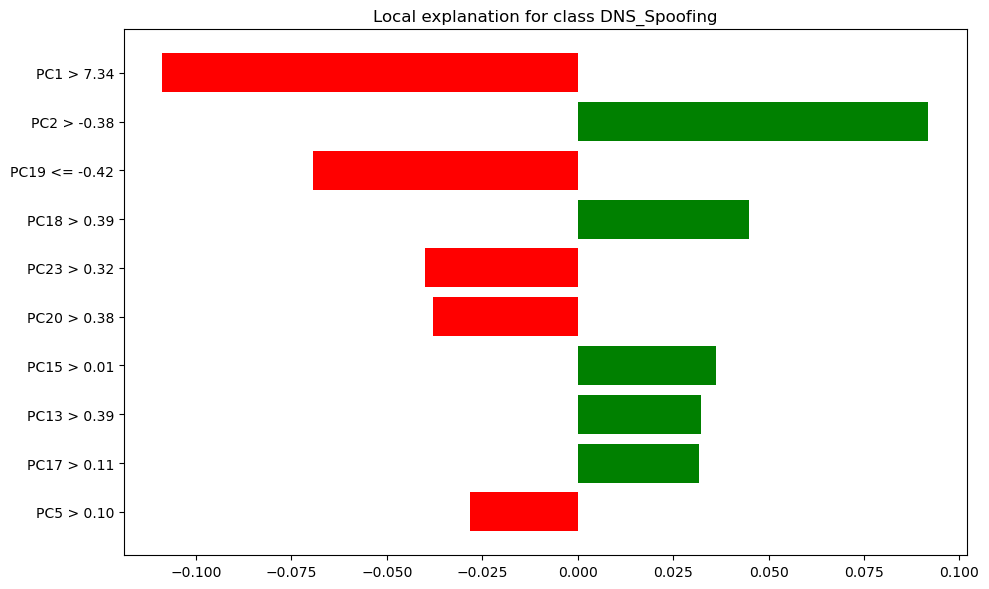

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt


feature_names = [f'PC{i+1}' for i in range(X_reduced.shape[1])]
model_to_explain = rf_model_attack

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_reduced),
    mode='classification',
    feature_names=feature_names,
    categorical_features=[],
    verbose=False,
    class_names=model_to_explain.classes_,
    discretize_continuous=True 
)


instance_idx = 5
instance = X_reduced[instance_idx].reshape(1, -1)

exp = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=lambda x: model_to_explain.predict_proba(x),
    num_features=10,
    num_samples=1000  
)


fig = exp.as_pyplot_figure(label=1)  
fig.set_size_inches(10, 6)         

plt.tight_layout()
plt.savefig("lime_explanation.png", dpi=300)
plt.show()
